# Potato Disease Classification with CNN: augmented imbalance dataset

# 1. Create new folder for augmented data

In [1]:
import os

src_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato/Potato___Healthy"
aug_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato/Potato___Healthy_Aug"

os.makedirs(aug_dir, exist_ok=True)


## 2. Generate healthy leave dataset

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


## 3. Generate until 1000 pictures for healthy leave pictures

In [3]:
import glob

target_count = 1000
current_images = glob.glob(os.path.join(src_dir, "*.jpg"))  # or .png if needed
n_existing = len(current_images)
to_generate = target_count - n_existing

print(f"Existing: {n_existing}, need to generate: {to_generate}")

i = 0
for img_path in current_images:
    img = load_img(img_path)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # generate 5 new variants per original image (adjust as needed)
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=aug_dir,
                              save_prefix='aug',
                              save_format='jpg'):
        i += 1
        if i >= to_generate:
            break
    if i >= to_generate:
        break


Existing: 152, need to generate: 848


## 4. Regroup all healthy leaves dataset from original and augmented

In [6]:
import shutil

final_healthy_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato/Potato___Healthy_Final"
os.makedirs(final_healthy_dir, exist_ok=True)

# Copy original
for f in glob.glob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(f, final_healthy_dir)

# Copy augmented
for f in glob.glob(os.path.join(aug_dir, "*.jpg")):
    shutil.copy(f, final_healthy_dir)


## 5. Load dataset into TensorFlow

In [7]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 16

dest = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dest,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dest,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


Found 2965 files belonging to 3 classes.
Using 2372 files for training.
Found 2965 files belonging to 3 classes.
Using 593 files for validation.
Classes: ['Potato___Early_blight', 'Potato___Healthy_Final', 'Potato___Late_blight']


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dest,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2965 files belonging to 3 classes.
Using 2372 files for training.


## 6. Create simple CNN model

In [9]:
from tensorflow.keras import layers, models

def make_simple_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(train_ds.class_names)
model = make_simple_cnn(IMG_SIZE + (3,), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,051 (14.14 MB)

 Trainable params: 3,706,051 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the CNN model

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.6283 - loss: 62.3416 - val_accuracy: 0.8229 - val_loss: 0.9996
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.8532 - loss: 0.4167 - val_accuracy: 0.8364 - val_loss: 0.3967
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.8797 - loss: 0.3411 - val_accuracy: 0.8651 - val_loss: 0.3499
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.8998 - loss: 0.3392 - val_accuracy: 0.8887 - val_loss: 0.2994
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9268 - loss: 0.2608 - val_accuracy: 0.8803 - val_loss: 0.3076
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9559 - loss: 0.1313 - val_accuracy: 0.8870 - val_loss: 0.3140
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9621 - loss: 0.1208 - val_accuracy: 0.8347 - val_loss: 0.7606
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9215 - loss: 

## 8. Evaluate the CNN model

In [11]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8973 - loss: 0.3206 
Validation accuracy: 0.907


### 9. Plot the learning curve

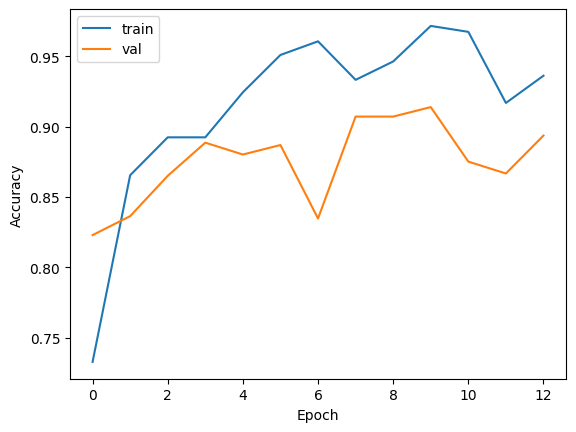

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


## 10. Make predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


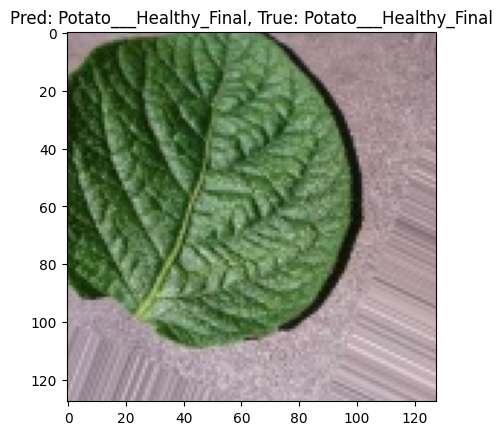

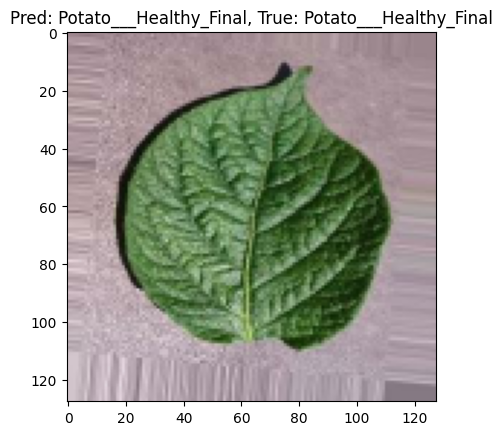

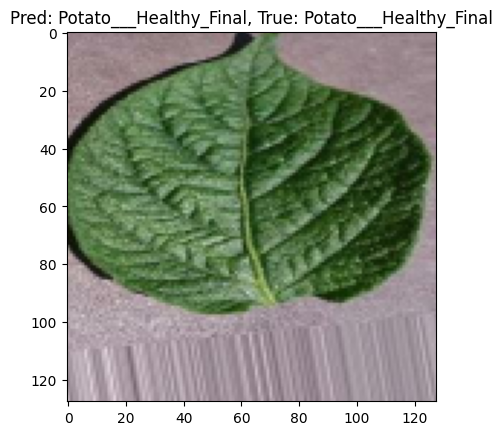

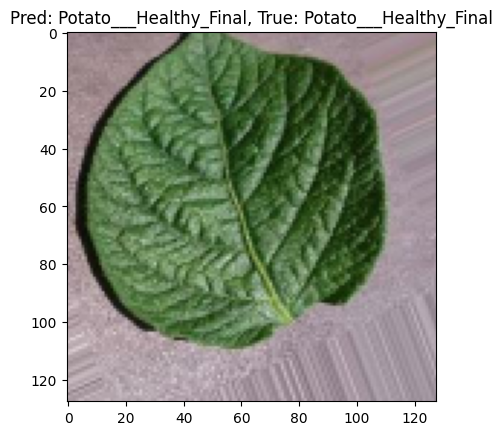

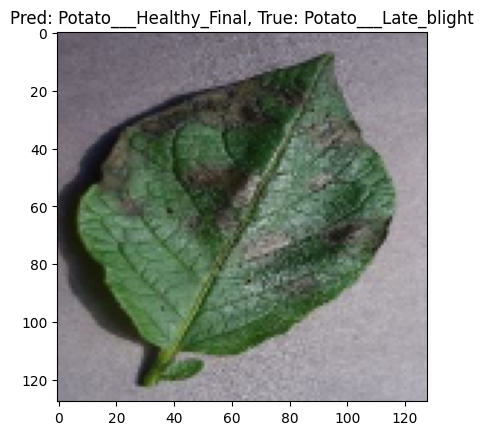

In [13]:
import numpy as np

class_names = train_ds.class_names

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[np.argmax(preds[i])]}, True: {class_names[np.argmax(labels[i])]}")
        plt.show()

## Conclusion
1. The train accuracy and validation accuracy quite similar around 0.9. It means the augmented technique for healthy leaves dataset helps the model to not discriminate the minority.
2. Try to use the pretrained model to increase the accuracy.